In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit

from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


基本変数定義

In [2]:
sampling_flg=0 #サンプリング有無をコントロール
submit_flg=1 #保存するかをコントロール（サンプリングしない時のみ）

SEED=12345
sample_num=10000
fold_num=5

#train関連
train_dir='../../02_feature/101_train.csv'
train_drop_col=['ID_code', 'target']
train_label='target'

#test関連
test_dir='../../02_feature/101_test.csv'
test_drop_col=['ID_code']

#結果ファイル関連　nameは自分の名前に変更する
train_preds_dir='../../03_predict_train/oka_243_LightGBM_train.csv'
test_preds_dir='../../04_predict_test/oka_243_LightGBM_submission.csv'
save_col_name='oof_xgb'

sample_submission_dir='../../01_input/sample_submission.csv'
submission_target_col_name='target'
submission_id_col_name='ID_code'

前処理

In [3]:
#ロード
train_df=pd.read_csv(train_dir)
test_df=pd.read_csv(test_dir)

In [4]:
#サンプリング
if sampling_flg ==1:
    train_df=train_df.sample(n=sample_num,random_state=SEED)
    test_df=test_df.sample(n=sample_num,random_state=SEED)

In [5]:
#x,y作成
x_train=train_df.drop(train_drop_col,axis=1)
y_train=train_df[train_label]
x_test=test_df.drop(test_drop_col,axis=1)

モデル実行

In [6]:
#model_param
param = {
    "objective" : "binary", 
    "boost":"gbdt",
    "metric":"auc",
    "boost_from_average":"false",
    "num_threads":28,
    "learning_rate" : 0.01,
    "num_leaves" : 13,
    "max_depth":-1,
    "tree_learner" : "serial",
    "feature_fraction" : 0.05,
    "bagging_freq" : 5,
    "bagging_fraction" : 0.4,
    "min_data_in_leaf" : 80,
    "min_sum_hessian_in_leaf" : 10.0,
    "verbosity" : 1,
    'seed': 44000,
    }

In [7]:
clf=KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300,
                               tol=0.0001,precompute_distances='auto', verbose=0,
                               random_state=11111, copy_x=True, n_jobs=1)
clf.fit(x_train)
pred=clf.predict(x_test)
type(pred)

numpy.ndarray

In [8]:
def create_kmean(in_trn_x,in_val_x,in_test_x):
    print(in_test_x.shape)
    new_trn=in_trn_x
    new_val=in_val_x
    new_test=in_test_x
    for i in range(2,20):
        print(i)
        clf=KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300,
                               tol=0.0001,precompute_distances='auto', verbose=0,
                               random_state=11111, copy_x=True, n_jobs=1)
        clf.fit(in_trn_x)
        pred=clf.predict(in_trn_x)
        new_trn['kmeans_'+str(i)]=pred
        pred=clf.predict(in_val_x)
        new_val['kmeans_'+str(i)]=pred
        pred=clf.predict(in_test_x)
        new_test['kmeans_'+str(i)]=pred
        
        new_trn=pd.get_dummies(new_trn,columns=['kmeans_'+str(i)],drop_first=True)
        new_val=pd.get_dummies(new_val,columns=['kmeans_'+str(i)],drop_first=True)
        new_test=pd.get_dummies(new_test,columns=['kmeans_'+str(i)],drop_first=True)
        
    return new_trn,new_val,new_test

In [9]:
x_test.head

<bound method NDFrame.head of         Unnamed: 0    var_0    var_1    var_2    var_3    var_4    var_5  \
0                0  11.0656   7.7798  12.9536   9.4292  11.4327  -2.3805   
1                1   8.5304   1.2543  11.3047   5.1858   9.1974  -4.0117   
2                2   5.4827 -10.3581  10.1407   7.0479  10.2628   9.8052   
3                3   8.5374  -1.3222  12.0220   6.5749   8.8458   3.1744   
4                4  11.7058  -0.1327  14.1295   7.7506   9.1035  -8.5848   
5                5   5.9862  -2.2913   8.6058   7.0685  14.2465  -8.6761   
6                6   8.4624  -6.1065   7.3603   8.2627  12.0104  -7.2073   
7                7  17.3035  -2.4212  13.3989   8.3998  11.0777   9.6449   
8                8   6.9856   0.8402  13.7161   4.7749   8.6784 -13.7607   
9                9  10.3811  -6.9348  14.6690   9.0941  11.9058 -10.8018   
10              10   8.3431  -4.1427   9.1985   9.8229  11.2494   2.9678   
11              11  10.6137  -2.1898   8.9090   3.8014  13

In [10]:
folds = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=SEED)
oof_preds = np.zeros((len(x_train), 1))
test_preds = np.zeros((len(x_test), 1))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    x_test=test_df.drop(test_drop_col,axis=1)
    print("\n")
    print("Fold {}".format(fold_))
    trn_x,trn_y = x_train.iloc[trn_idx], y_train.iloc[trn_idx]
    val_x,val_y = x_train.iloc[val_idx], y_train.iloc[val_idx]
    
    new_trn_x,new_val_x,new_x_test=create_kmean(trn_x,val_x,x_test)
    #print(new_trn_x)
    
    trn_data = lgb.Dataset(new_trn_x,trn_y)
    val_data = lgb.Dataset(new_val_x,val_y)
    
    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    val_pred = clf.predict(new_val_x, num_iteration=clf.best_iteration)
    test_pred = clf.predict(new_x_test, num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = new_trn_x.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    #print("val = {}".format(val_pred)
    oof_preds[val_idx, :] = val_pred.reshape((-1, 1))
    test_preds += test_pred.reshape((-1, 1))
    
test_preds /= fold_num
roc_score = roc_auc_score(y_train, oof_preds.ravel())
print("Overall AUC = {}".format(roc_score))



Fold 0
(200000, 201)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.901326	valid_1's auc: 0.882362
[2000]	training's auc: 0.91306	valid_1's auc: 0.89071
[3000]	training's auc: 0.921456	valid_1's auc: 0.894765
[4000]	training's auc: 0.927627	valid_1's auc: 0.897051
[5000]	training's auc: 0.932796	valid_1's auc: 0.898482
[6000]	training's auc: 0.937382	valid_1's auc: 0.899012
[7000]	training's auc: 0.94157	valid_1's auc: 0.899241
[8000]	training's auc: 0.945425	valid_1's auc: 0.899508
[9000]	training's auc: 0.949125	valid_1's auc: 0.899499
[10000]	training's auc: 0.95273	valid_1's auc: 0.899543
[11000]	training's auc: 0.956071	valid_1's auc: 0.899395
[12000]	training's auc: 0.95929	valid_1's auc: 0.899278
Early stopping, best iteration is:
[9619]	training's auc: 0.951402	valid_1's auc: 0.899665
AUC = 0.899665239296417


Fold 1
(200000, 201)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Training unti

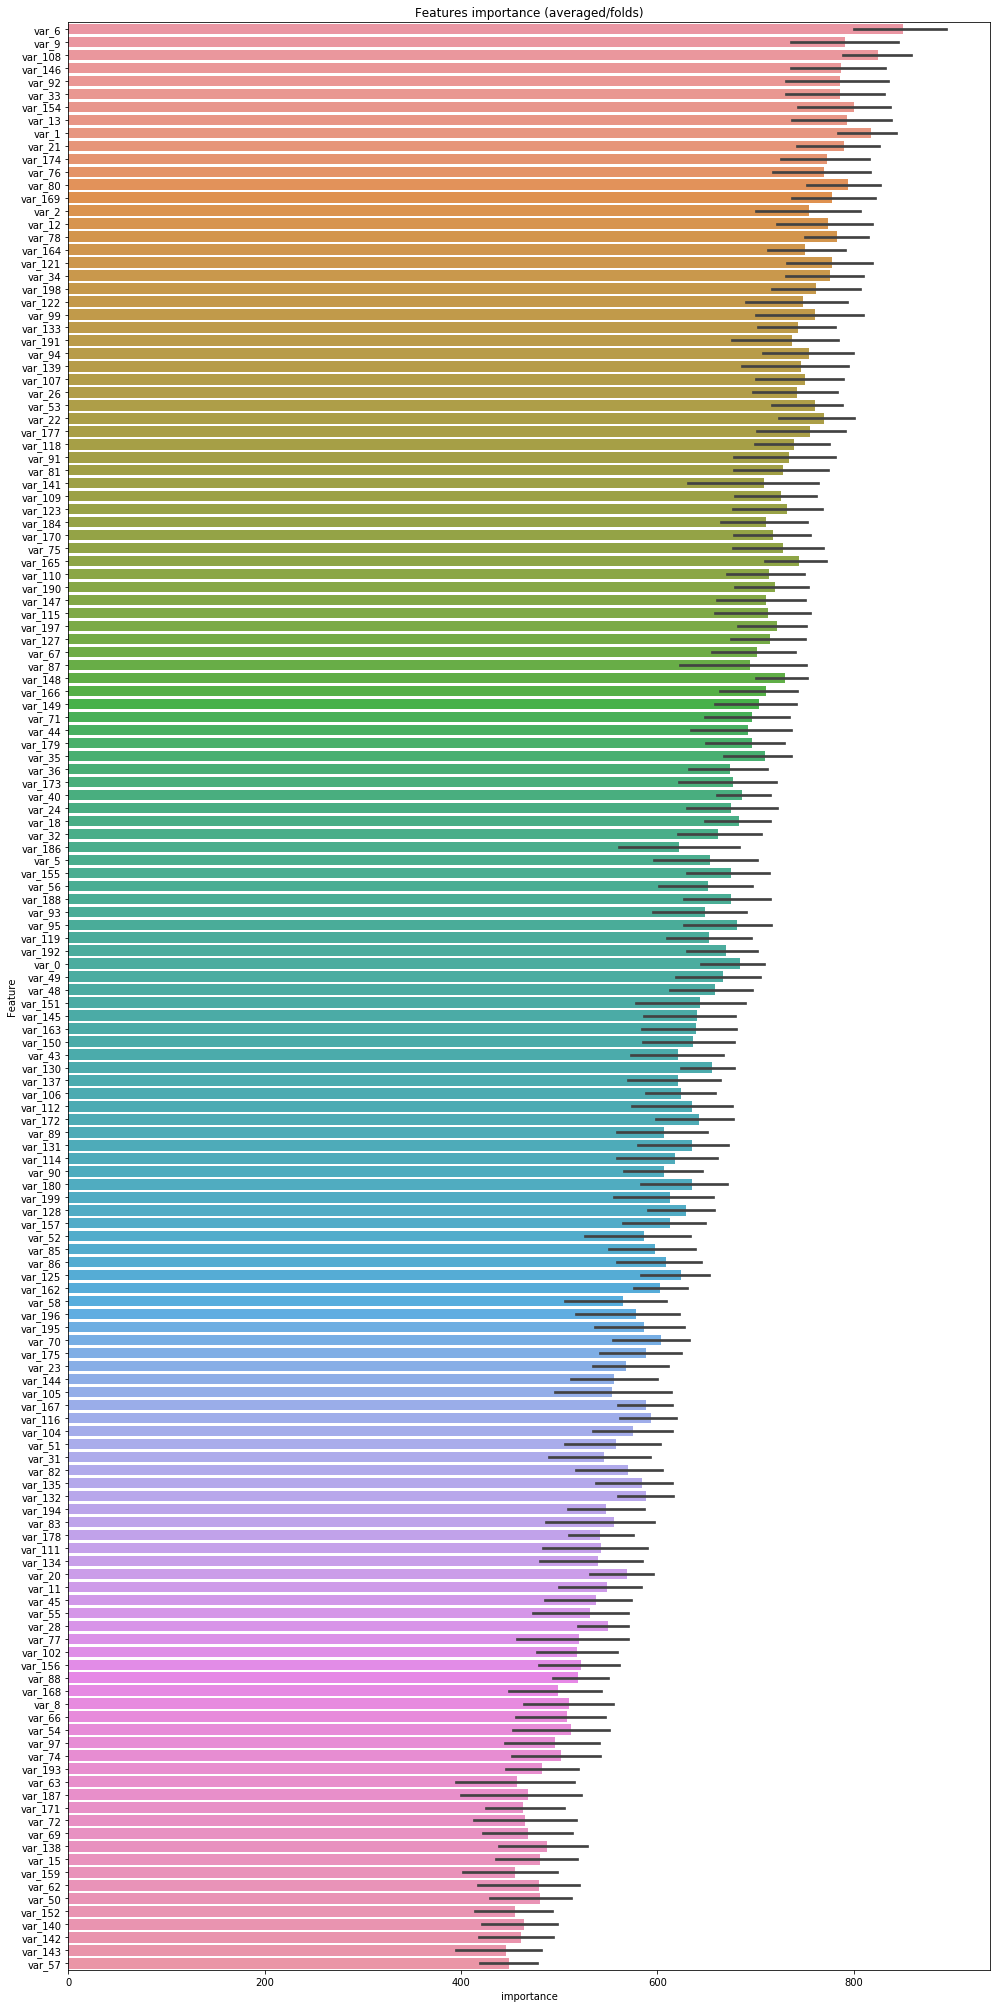

In [11]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('../../04_predict_test/241_FI.png')

In [12]:
#結果保存
if (submit_flg ==1 and sampling_flg==0):
    series_oof_preds = pd.Series(data=oof_preds[:,0], name=save_col_name, dtype='float')
    series_oof_preds.to_csv(train_preds_dir,header=True, index=False)

    sample = pd.read_csv(sample_submission_dir)
    sample.target = test_preds[:,0].astype(float)
    sample.ID_code = test_df['ID_code']
    sample.to_csv(test_preds_dir, index=False)
    

In [13]:
pd.set_option('display.max_rows', 500)
feature_importance_df

,Feature,importance,fold
0,Unnamed: 0,322,1
1,var_0,696,1
2,var_1,834,1
3,var_2,751,1
4,var_3,427,1
5,var_4,398,1
6,var_5,645,1
7,var_6,827,1
8,var_7,380,1
9,var_8,486,1
